<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Dataforst%C3%A5else-og-unders%C3%B8kelse-Pradeep/Bioco_Dataprosessering%2C_Dataforst%C3%A5else_og_Dataunders%C3%B8kelse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataforståelse og Dataundersøkelse

## Bibilotek og versjoner

Lasting av nødvendige bibiotek og pakker

In [ ]:
!pip install hoggorm
!pip install hoggormPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 942.2 kB/s eta 0:00:00


Importering av nødvendige bibliotek og pakker

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import missingno as msno

import hoggorm as ho
import hoggormplot as hop


import math
import time
import copy
import datetime

Versjon av benyttede bibliotek og pakker

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Pandas
print("Pandas:", pd.__version__)
# Numpy
print("Numpy:", np.__version__)
# Matplotlib
print("Matplotlib:", matplotlib.__version__)
# Seabort
print("Seaborn:", sns.__version__)
# Scikit learn
print("Scikit learn:", sklearn.__version__)
# Hoggorm
print("Hoggorm:", ho.__version__)
# Hoggorm plot
print("Hoggorm plot:", hop.__version__)
# Missigno
print("Missigno:", msno.__version__)
# Statsmodels
#print("Statsmodels:", statsmodels.__version__)
# Optuna
#print("Optuna:", optuna.__version__)
# Pyod
#print("PyOD: 1.1.4")
# LAMDA-SSL
#print("LAMDA_SSL: 1.0.2")

Pandas: 2.0.3
Numpy: 1.25.2
Matplotlib: 3.7.1
Seaborn: 0.13.1
Scikit learn: 1.2.2
Hoggorm: 0.13.3
Hoggorm plot: 0.13.2
Missigno: 0.5.2


## Funksjoner

### Funksjon for plotting av histogram

In [ ]:
def plot_histogram(df1,
                   df2=None,
                   labels=None,
                   min_max_dict=None,
                   figsize=(15, 20)):

  """

  """

  diskre_variabler = ['EnzymeCode', 'RawMaterialMix', 'Week', 'Day']
  farger = ["#20639B"] # seaborn standard blue

  fig = plt.figure(figsize=figsize)
  rute_nett = fig.add_gridspec(10, 3)

  n = 0
  i = 0

  for col in df1.columns:
      if i % 3 == 0:
          n += 1
          i = 0

      ax = fig.add_subplot(rute_nett[n, i])

      bins = 'auto'
      if df2 is not None:
        farger = ["#87CEEB", "#FF7F50"] # sky blue og coral
        if col not in diskre_variabler:
          bins = np.histogram_bin_edges(df1[col].dropna().tolist() + df2[col].dropna().tolist(), bins='auto')
        sns.histplot(x=col, data=df2, color=farger[1], ax=ax, stat='percent', label=labels[1], bins=bins, alpha=0.7)

      sns.histplot(x=col, data=df1, color=farger[0], ax=ax, stat='percent', label=labels[0], bins=bins, alpha=0.7)

      ax.set_xlabel(col)
      ax.set_ylabel('Andel', fontsize=10)
      ax.yaxis.set_major_formatter(PercentFormatter(100))
      ax.legend()

      if col not in diskre_variabler:
          ax.set_xticks([])
          if (min_max_dict is not None) and (col in min_max_dict):
            min_val, max_val = min_max_dict[col]
            ax.set_xlim(min_val, max_val)

      i += 1

  fig.tight_layout()
  plt.show()

### Funksjon for fordelinger

In [ ]:
def kategoriske_fordelinger(bioco_data):


  """

  """

  # Sjekker krav til kategorier
  kategoriske_variabler = ['EnzymeCode', 'RawMaterialMix']
  for col in kategoriske_variabler:
    if col not in bioco_data.columns:
      raise ValueError(f"Mangler '{col}' i data.")

  fordelinger = {}

  # Berenger frekvens aog andeler
  for col in kategoriske_variabler:

    frekvens = bioco_data[col].value_counts()
    andel = bioco_data[col].value_counts(normalize=True) * 100

    fordelings_data = pd.DataFrame({
        'Frekvens': frekvens,
        'Andel (%)': andel
    })

    fordelinger[col] = fordelings_data

  # Printer resultater
  for col, data in fordelinger.items():
    print(f"\n**Fordelingen i '{col}':**")
    print(data.to_markdown(numalign='left', stralign='left'))

In [ ]:
def respons_beskrivelse(data, responsvariabler):

  df_beskrivelse = pd.DataFrame({'Gjennomsnitt': data[responsvariabler].mean(),
                                'Median': data[responsvariabler].median(),
                                'Std': data[responsvariabler].std(),
                                'Std (Relativ %)': 100 * (data[responsvariabler].std()/data[responsvariabler].mean())})



  return df_beskrivelse

In [ ]:
def respons_enzym(rå_data, data, responsvariabler):

    result_dict = {}

    enzym_data = rå_data.merge(data,
                               left_index=True,
                               right_index=True,
                               how='inner',
                               suffixes=('','_drop'))['EnzymeCode']


    data_enzym = data.join(enzym_data)

    for respons in responsvariabler:
        grouped = data_enzym.groupby(['EnzymeCode'])[respons]
        result = grouped.agg(['mean', 'median', 'std']).unstack()
        result_dict[respons] = result

    return result_dict

In [ ]:
def respons_kategori(rå_data, data, responsvariabler):

    result_dict = {}

    enzym_data = rå_data.merge(data,
                               left_index=True,
                               right_index=True,
                               how='inner',
                               suffixes=('','_drop'))['EnzymeCode']

    material_data = rå_data.merge(data,
                                  left_index=True,
                                  right_index=True,
                                  how='inner',
                                  suffixes=('','_drop'))['RawMaterialMix']


    data_enzym_materiale = data.join(enzym_data).join(material_data)

    for respons in responsvariabler:
        grouped = data_enzym_materiale.groupby(['EnzymeCode', 'RawMaterialMix'])[respons]
        result = grouped.agg(['mean', 'median', 'std']).unstack()
        result_dict[respons] = result

    return result_dict

In [ ]:
def plot_histogram_enzym(df: pd.DataFrame,
                         enzym_variabel: str,
                         min_max_dict=None,
                         figsize=(10, 15)):

    """

    """

    kolonner = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    fig = plt.figure(figsize=figsize)
    rute_nett = fig.add_gridspec(10, 3)

    n = 0
    i = 0

    for kolonne in kolonner:
        if i % 3 == 0:
            n += 1
            i = 0

        ax = fig.add_subplot(rute_nett[n, i])

        for enzym_type in df[enzym_variabel].unique():
            subset = df[df[enzym_variabel] == enzym_type]
            sns.histplot(subset[kolonne], ax=ax, kde=True, label=enzym_type, element='step', stat='density', common_norm=False)

        ax.set_xlabel(f'{kolonne} (per enzymtype)')
        ax.set_ylabel('Tetthet')
        ax.legend()

        # Fjerner akseverdier og legger til intervaller
        ax.set_xticks([])
        if min_max_dict is not None and kolonne in min_max_dict:
            min_val, max_val = min_max_dict[kolonne]
            ax.set_xlim(min_val, max_val)

        i += 1

    plt.subplots_adjust(hspace=0.5)
    plt.show()

### Funksjon for oppdeling i markert og umarkert del etter responsvariabel

In [ ]:
def splitt_markert_umarkert_respons(data,
                                    respons):
    """
    Deler datasett i markert og umarkert del etter responstype
    """

    # Splitter data etter dagsinformasjon om produksjonstyper
    markert_sett = data.dropna(subset=[respons])
    umarkert_sett = data[data[respons].isna()]

    return markert_sett, umarkert_sett

## Importering av data

Importering av data og omgjøring til DataFrame

In [ ]:

# Velger første kolonne med dato og tid som index
bioco_rå_data = pd.read_csv('/content/drive/MyDrive/MasterV24/BiocoData.csv',
                            header=0,
                            sep=';',
                            index_col=0)

# Gjør om index med dato og tid til riktig format
bioco_rå_data.index = pd.to_datetime(bioco_rå_data.index,
                                     format='%d-%m-%Y %H:%M:%S.%f')

## Undersøkelse av data

Sjekking av kontinuitet i tidsereidata

In [ ]:
def konverter_tid(sekunder):
  tid = time.gmtime(sekunder)
  dager, timer, minutter = tid[2], tid[3], tid[4]
  return dager, timer, minutter


def analyser_tidserier(bioco_rå_data, max_diff_seconds=60.0):
    # Lager lister for å lagre start- og slutttidspunkt på kontinuerlige tidserier
    tid_observasjon_start = []
    tid_observasjon_slutt = []

    # Legger til første observasjon i listen med startstider
    tid_observasjon_start.append(bioco_rå_data.index[0])

    # Går igjennom datasettet og lagrer slutt- og startstid på tidsintervaller
    # mer enn max_diff_seconds sekunder
    for i in range(1, len(bioco_rå_data.index)):
        tidsdiff = bioco_rå_data.index[i] - bioco_rå_data.index[i-1]
        if tidsdiff.total_seconds() > max_diff_seconds:
            tid_observasjon_slutt.append(bioco_rå_data.index[i-1])
            tid_observasjon_start.append(bioco_rå_data.index[i])

    # Legger til siste observasjonstid i datasettet
    tid_observasjon_slutt.append(bioco_rå_data.index[-1])

    print("Det er {} kontinuerlige observasjoner med intervall på {} min:".format(len(tid_observasjon_slutt),
                                                                                  int(max_diff_seconds/60)))

    lengst_kontinuitet = 0
    kortest_kontinuitet = math.inf
    lengst_passiv = 0
    kortest_passiv = math.inf

    forrige_stopp = False
    forrige_korteste_passiv = False

    # Får oversikt over kontinuerlige datasett
    for start, slutt in zip(tid_observasjon_start, tid_observasjon_slutt):
        uke = start.isocalendar().week

        print("Uke {}: Tidsintervallet {} til {}"
              " er kontinuerlig tidsserie".format(uke, start, slutt))

        # Beregner kontiuitet i tidseriedata
        kontinuitet = (slutt - start).total_seconds()

        if kontinuitet < kortest_kontinuitet:
            kortest_kontinuitet = kontinuitet
        if kontinuitet >= lengst_kontinuitet:
            lengst_kontinuitet = kontinuitet

        # Beregner tid mellom sist tidspunkt for datasinnsamling og nest tidspunkt
        # for datainnsamling
        if forrige_stopp:
            passiv = (start - forrige_stopp).total_seconds()
            # Ser bort i fra mangel på datainnsamling i helger og stopp mellom uke 50
            # til uke 26
            if konverter_tid(passiv)[0] - 1 < 2:
                if passiv < kortest_passiv:
                    forrige_korteste_passiv = kortest_passiv
                    kortest_passiv = passiv
                if passiv >= lengst_passiv:
                    lengst_passiv = passiv

        forrige_stopp = slutt

    print("Lengst kontinuitet: {} dager, {} timer og {} minutter".format(konverter_tid(lengst_kontinuitet)[0]-1,
                                                                         konverter_tid(lengst_kontinuitet)[1],
                                                                         konverter_tid(lengst_kontinuitet)[2]))
    print("Kortest kontinuitet: {} dager, {} timer og {} minutter".format(konverter_tid(kortest_kontinuitet)[0]-1,
                                                                          konverter_tid(kortest_kontinuitet)[1],
                                                                          konverter_tid(kortest_kontinuitet)[2]))
    print("Lengst passivitet: {} dager, {} timer og {} minutter".format(konverter_tid(lengst_passiv)[0]-1,
                                                                        konverter_tid(lengst_passiv)[1],
                                                                        konverter_tid(lengst_passiv)[2]))
    print("Forrige kortest passivitet: {} dager, {} timer og {} minutter".format(konverter_tid(forrige_korteste_passiv)[0]-1,
                                                                         konverter_tid(forrige_korteste_passiv)[1],
                                                                         konverter_tid(forrige_korteste_passiv)[2]))

In [ ]:
# Finner antall kontinuerlige serier i datasett, med fast angitt intervall på 1 min
analyser_tidserier(bioco_rå_data,
                   max_diff_seconds=1*60.0)

Det er 39 kontinuerlige observasjoner med intervall på 1 min:
Uke 44: Tidsintervallet 2022-10-31 15:30:00 til 2022-11-02 05:19:00 er kontinuerlig tidsserie
Uke 44: Tidsintervallet 2022-11-02 10:47:00 til 2022-11-05 00:04:00 er kontinuerlig tidsserie
Uke 45: Tidsintervallet 2022-11-07 16:24:00 til 2022-11-08 23:57:00 er kontinuerlig tidsserie
Uke 45: Tidsintervallet 2022-11-09 01:39:00 til 2022-11-09 06:37:00 er kontinuerlig tidsserie
Uke 45: Tidsintervallet 2022-11-09 11:11:00 til 2022-11-12 03:59:00 er kontinuerlig tidsserie
Uke 46: Tidsintervallet 2022-11-14 18:01:00 til 2022-11-18 06:15:00 er kontinuerlig tidsserie
Uke 46: Tidsintervallet 2022-11-18 08:45:00 til 2022-11-19 03:44:00 er kontinuerlig tidsserie
Uke 47: Tidsintervallet 2022-11-21 16:23:00 til 2022-11-23 06:05:00 er kontinuerlig tidsserie
Uke 47: Tidsintervallet 2022-11-23 08:59:00 til 2022-11-23 13:59:00 er kontinuerlig tidsserie
Uke 47: Tidsintervallet 2022-11-23 20:15:00 til 2022-11-26 00:49:00 er kontinuerlig tidsseri

Informasjon om bioco rådata

In [ ]:
bioco_rå_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EnzymeCode        43251 non-null  object 
 1   RawMatFlow        43196 non-null  float64
 2   WaterFlow         43196 non-null  float64
 3   RawMatPercent     43196 non-null  float64
 4   RawMaterialMix    43251 non-null  object 
 5   NIRfat            29064 non-null  float64
 6   NIRprotein        27520 non-null  float64
 7   NIRash            29275 non-null  float64
 8   NIRwater          29293 non-null  float64
 9   TT07              43201 non-null  float64
 10  TT08              43206 non-null  float64
 11  PT03              43226 non-null  float64
 12  TT20              43226 non-null  float64
 13  TT09              43236 non-null  float64
 14  TT12              43251 non-null  float64
 15  product_sampleID  540 non-null    object 
 16  Colla

In [ ]:
respons_oppsummering = respons_beskrivelse(bioco_rå_data, ['Mw', 'SmallMolecules', 'BrixAdjusted'])
respons_oppsummering

,Gjennomsnitt,Median,Std,Std (Relativ %)
Mw,7192.855368,6499.326468,2287.708090,31.805284
SmallMolecules,10.971490,10.829766,1.577259,14.375974
BrixAdjusted,0.105959,0.106339,0.018728,17.674453


Fordelingen i Enzymtyper og Råmaterialeblanding

In [ ]:
kategoriske_fordelinger(bioco_rå_data)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 29213      | 67.5429     |
| A1           | 5482       | 12.6749     |
| D            | 2272       | 5.25306     |
| B            | 2270       | 5.24843     |
| C            | 2080       | 4.80914     |
| E            | 1934       | 4.47157     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 42607      | 98.511      |
| Turkey           | 355        | 0.82079     |
| Chicken          | 289        | 0.668193    |


## Førbehandling av data

Utelukking av kolonner i datasett før videre undersøkelse

In [ ]:
# Dropper kolonner "product_SampleID" og "testset" som ikke er relevant
bioco_data = bioco_rå_data.drop(columns=['product_sampleID', 'testset'])

# Dropper kolonner "Brix", "Yield" og "Yield_withoutNIR", da "BrixAdjusted"
# dekker samme informasjon
bioco_data.drop(columns=['Brix', 'Yield', 'Yield_withoutNIR'],
                inplace=True)

Informasjon om førbehandlet datasett

In [ ]:
bioco_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeCode      43251 non-null  object 
 1   RawMatFlow      43196 non-null  float64
 2   WaterFlow       43196 non-null  float64
 3   RawMatPercent   43196 non-null  float64
 4   RawMaterialMix  43251 non-null  object 
 5   NIRfat          29064 non-null  float64
 6   NIRprotein      27520 non-null  float64
 7   NIRash          29275 non-null  float64
 8   NIRwater        29293 non-null  float64
 9   TT07            43201 non-null  float64
 10  TT08            43206 non-null  float64
 11  PT03            43226 non-null  float64
 12  TT20            43226 non-null  float64
 13  TT09            43236 non-null  float64
 14  TT12            43251 non-null  float64
 15  Collagen        99 non-null     float64
 16  Mw              540 non-null    float64
 

## Undersøkelse av mangel på data

In [ ]:
bioco_data.isnull().sum().sort_values(ascending=True)

EnzymeCode            0
TT12                  0
RawMaterialMix        0
TT09                 15
TT20                 25
PT03                 25
TT08                 45
TT07                 50
RawMatPercent        55
WaterFlow            55
RawMatFlow           55
NIRwater          13958
NIRash            13976
NIRfat            14187
NIRprotein        15731
SmallMolecules    42711
Mw                42711
BrixAdjusted      42711
Collagen          43152
dtype: int64

Totalt manglende verdier og Andel totalt manglende verdier, fordelt på sekundær og kvalitetsmålinger

In [ ]:
# Antall rader og kolonner
n_rader = bioco_data.shape[0]
n_variabler = len(bioco_data.columns)

print(f"Totalt manglende verdier:\
 {(bioco_data.isnull().sum().sum())}\
 og andel totalt manglende verdier:\
  {round((bioco_data.isnull().sum().sum())/(n_rader*n_variabler), 3)}")

Totalt manglende verdier: 229462 og andel totalt manglende verdier:  0.279


In [ ]:
n_observasjoner = bioco_data.shape[0]

sekundær_målinger = bioco_data.columns[:-4]
n_sekundær_målinger= len(sekundær_målinger)

kvalitetsmålinger = bioco_data.columns[-4:]
n_kvalitetsmålinger = len(kvalitetsmålinger)


# Manglende verdier i data om sekundærmålinger
print(f"Totalt manglende verdier i sekundærmålinger:\
 {(bioco_data[sekundær_målinger].isnull().sum().sum())}\
 og andel totalt manglende verdier:\
  {round((bioco_data[sekundær_målinger].isnull().sum().sum())/(n_observasjoner*n_sekundær_målinger), 3)}")

# Manglende verdier i data om kvalitetsmålinger
print(f"Totalt manglende verdier i kvalitetsmålinger:\
 {(bioco_data[kvalitetsmålinger].isnull().sum().sum())}\
 og andel totalt manglende verdier:\
  {round((bioco_data[kvalitetsmålinger].isnull().sum().sum())/(n_observasjoner*n_kvalitetsmålinger), 3)}")

Totalt manglende verdier i sekundærmålinger: 58177 og andel totalt manglende verdier:  0.09
Totalt manglende verdier i kvalitetsmålinger: 171285 og andel totalt manglende verdier:  0.99


Visuell oversikt over mangel på data

<Axes: >

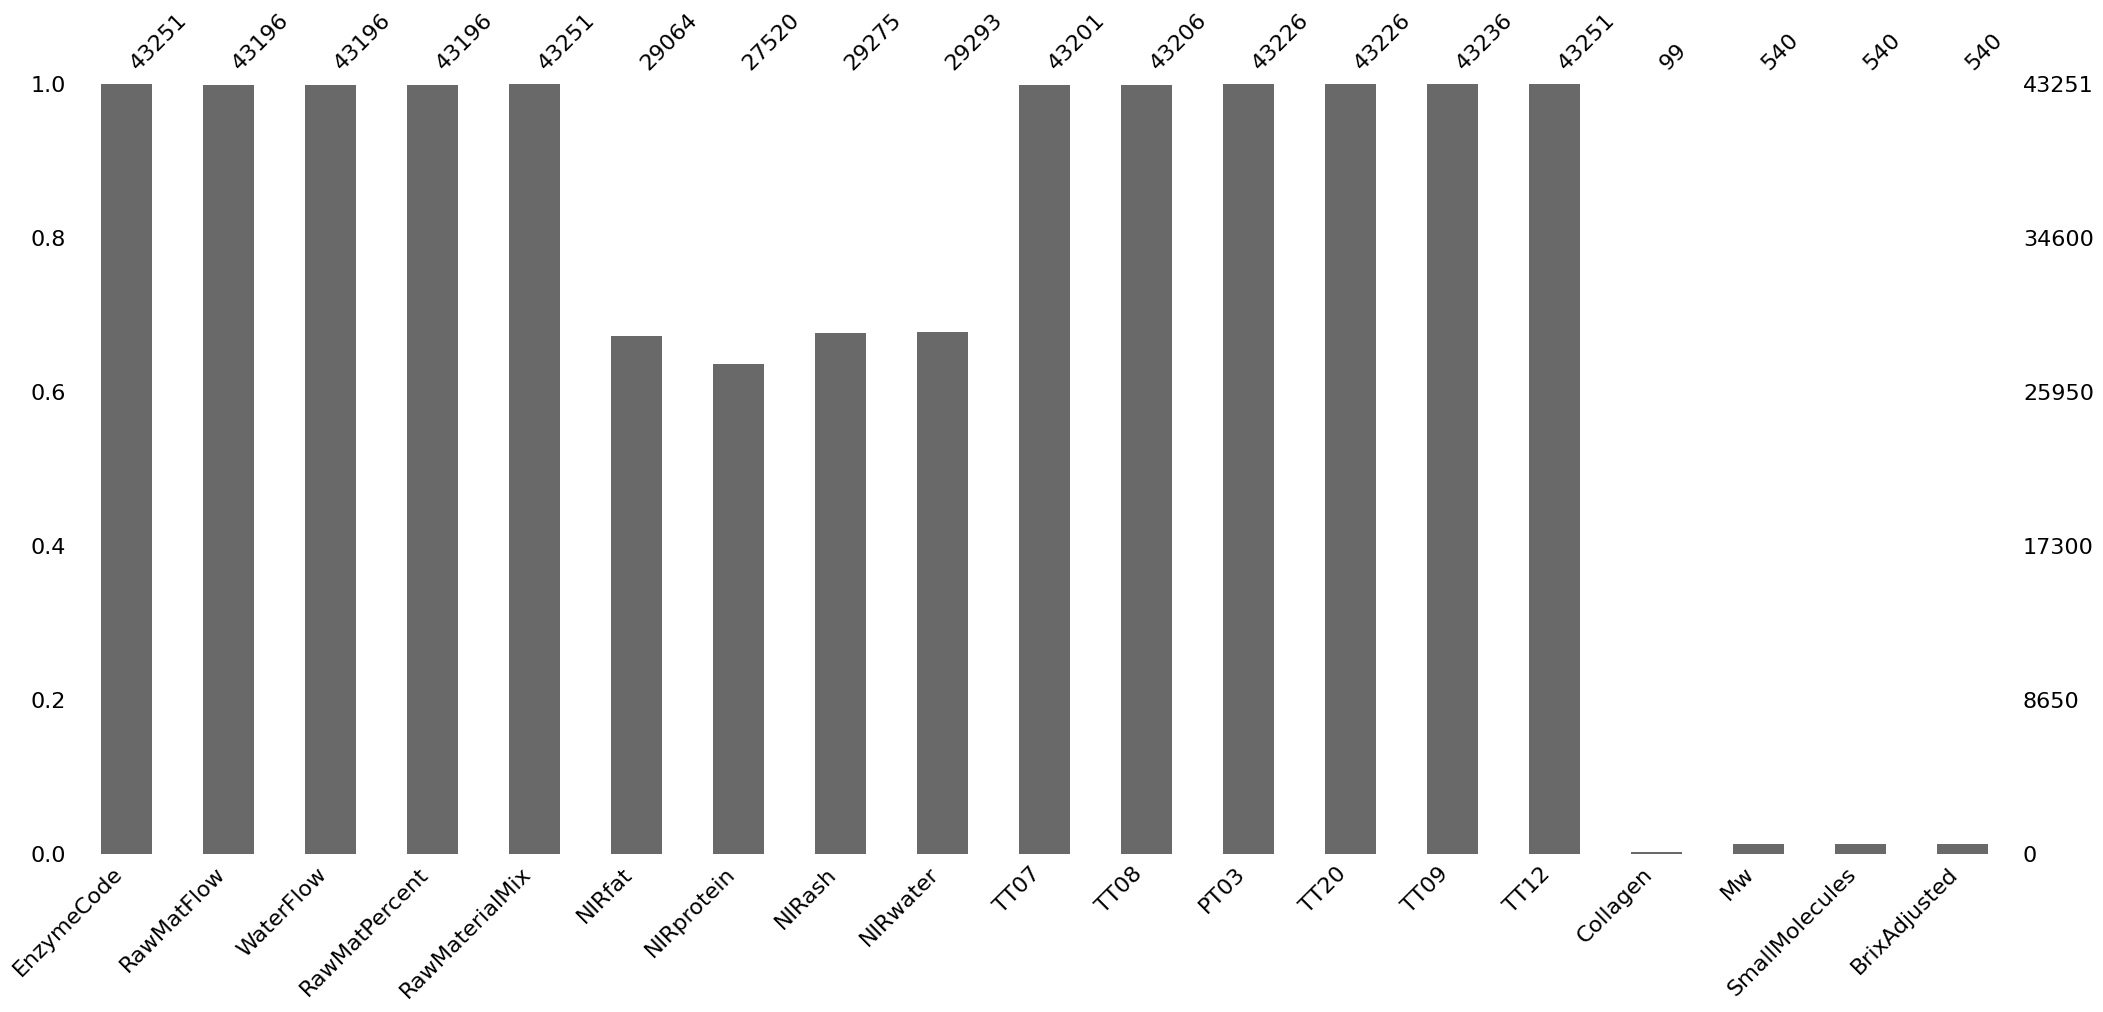

In [ ]:
msno.bar(bioco_data)

<Axes: >

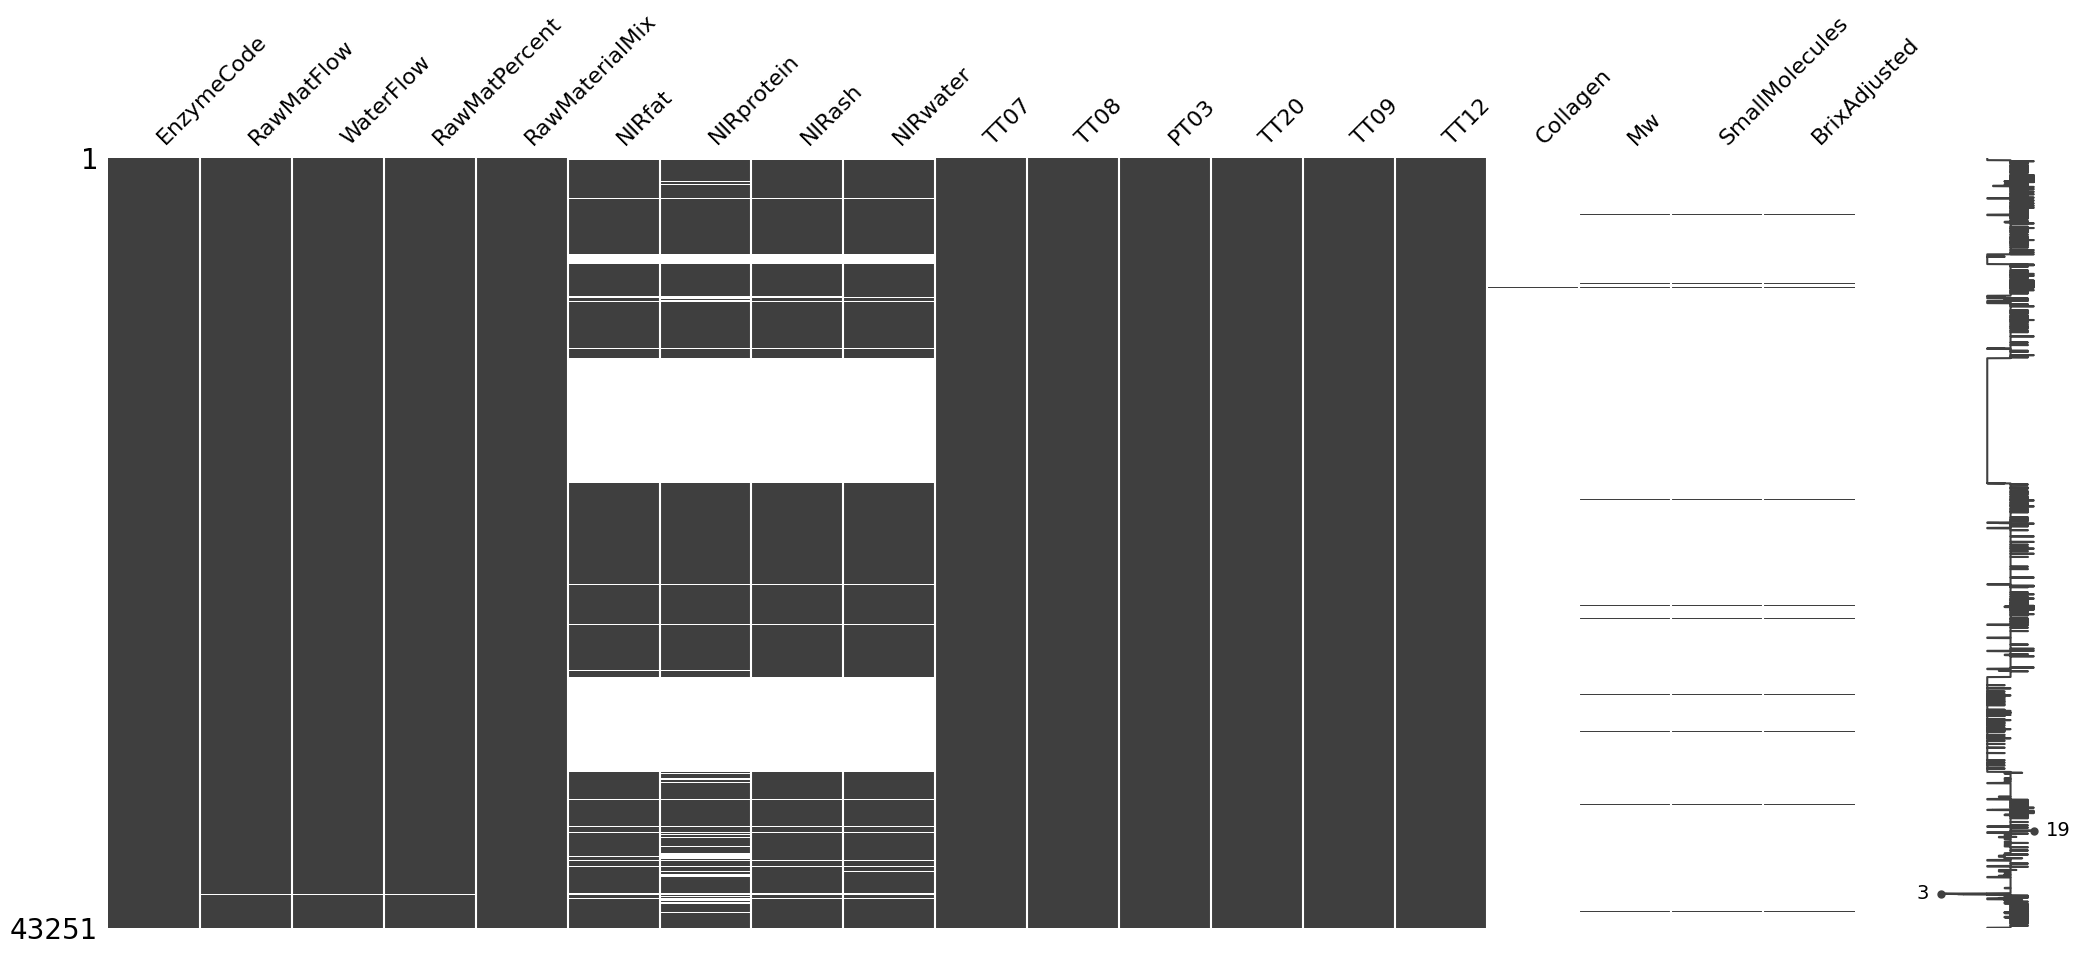

In [ ]:
msno.matrix(bioco_data)

# Datafordeling

## Fordeling i hele datasett

In [ ]:
# Definerer bestemte aksegrener for x_akse for sammenlignbarhet uten synlige verdier
# Bruker maks og min verdier
min_max_dict_hel = {}
for col in bioco_data.columns:
  min_max_dict_hel[col] = [bioco_data[col].min(), bioco_data[col].max()]

Violin plot

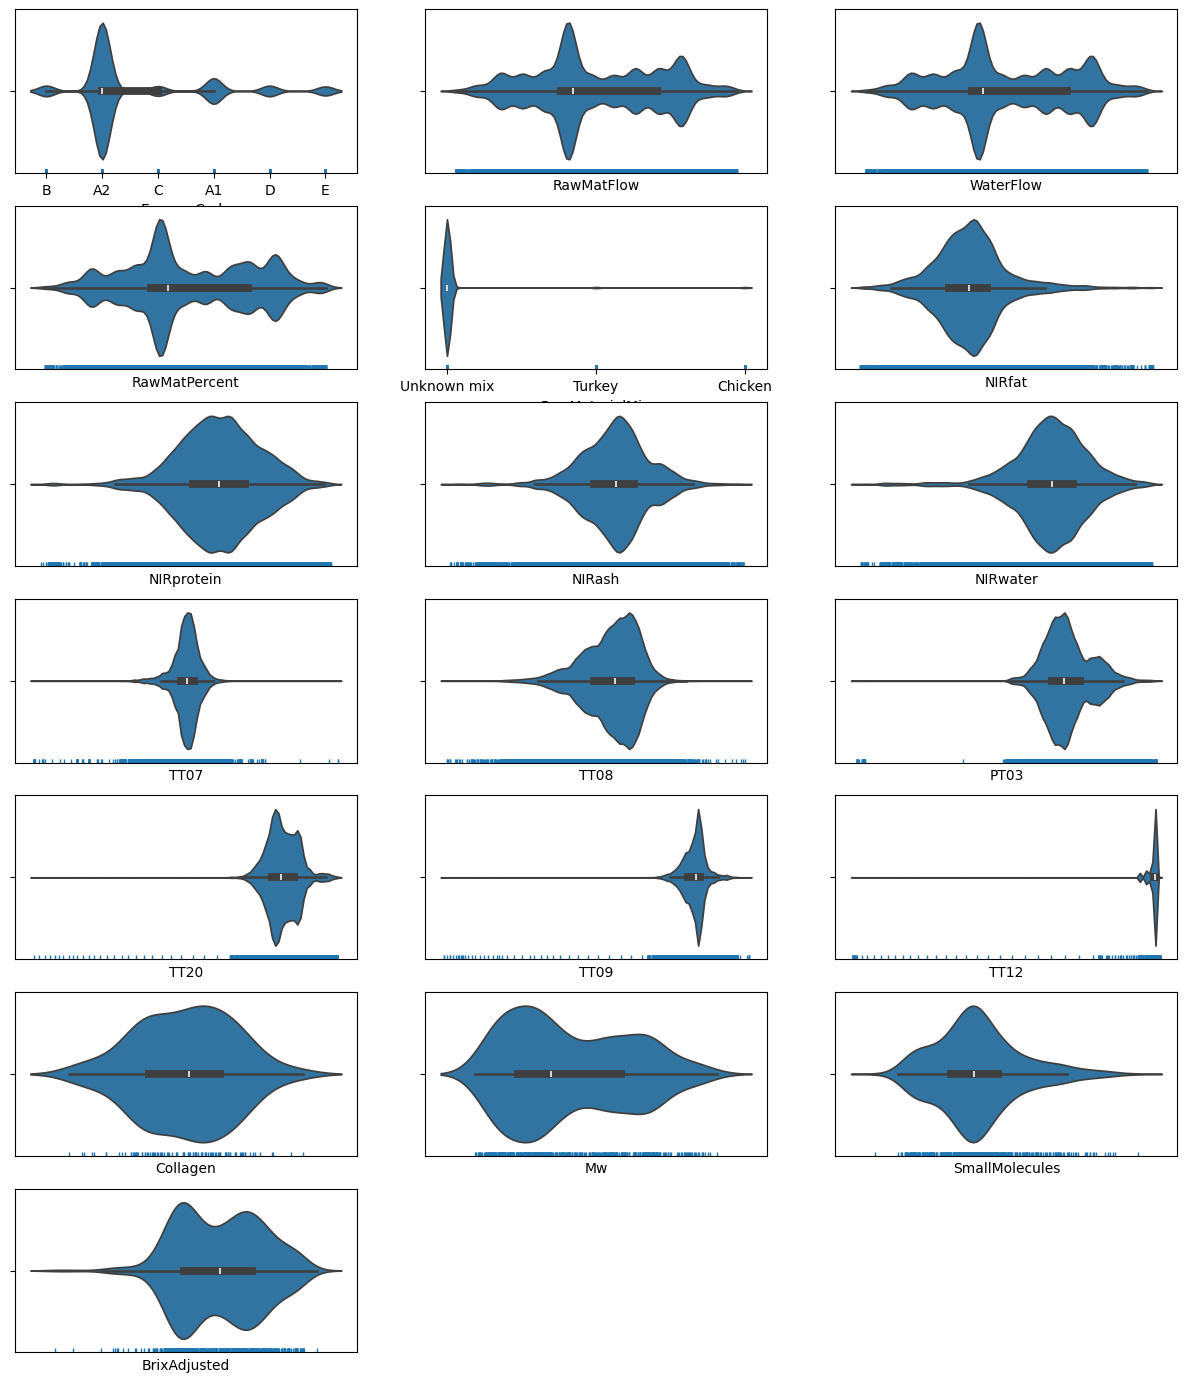

In [ ]:
fig = plt.figure(figsize=(15,20))
antall_kolonnner = len(bioco_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), bioco_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = bioco_data)
  sns.rugplot(x=bioco_data[indeks])

  # Utelukker sensitiv informasjon
  if indeks not in ['EnzymeCode', 'RawMaterialMix']:
    ax.set_xticks([])
  i += 1

Lager kopi av datasett for merinformasjon om tidsintervaller som dag og uke

In [ ]:
bioco_data_tid = copy.deepcopy(bioco_data)
bioco_data_tid['Week'] = bioco_data_tid.index.isocalendar().week
bioco_data_tid['Day'] = (bioco_data_tid.index.isocalendar().day)

# Ordner Enzymtype data etter alfabetisk rekkefølge for visualisering
bioco_data_tid['EnzymeCode'] = pd.Categorical(bioco_data_tid['EnzymeCode'],
                                         categories=['A1', 'A2', 'B', 'C', 'D', 'E'])

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


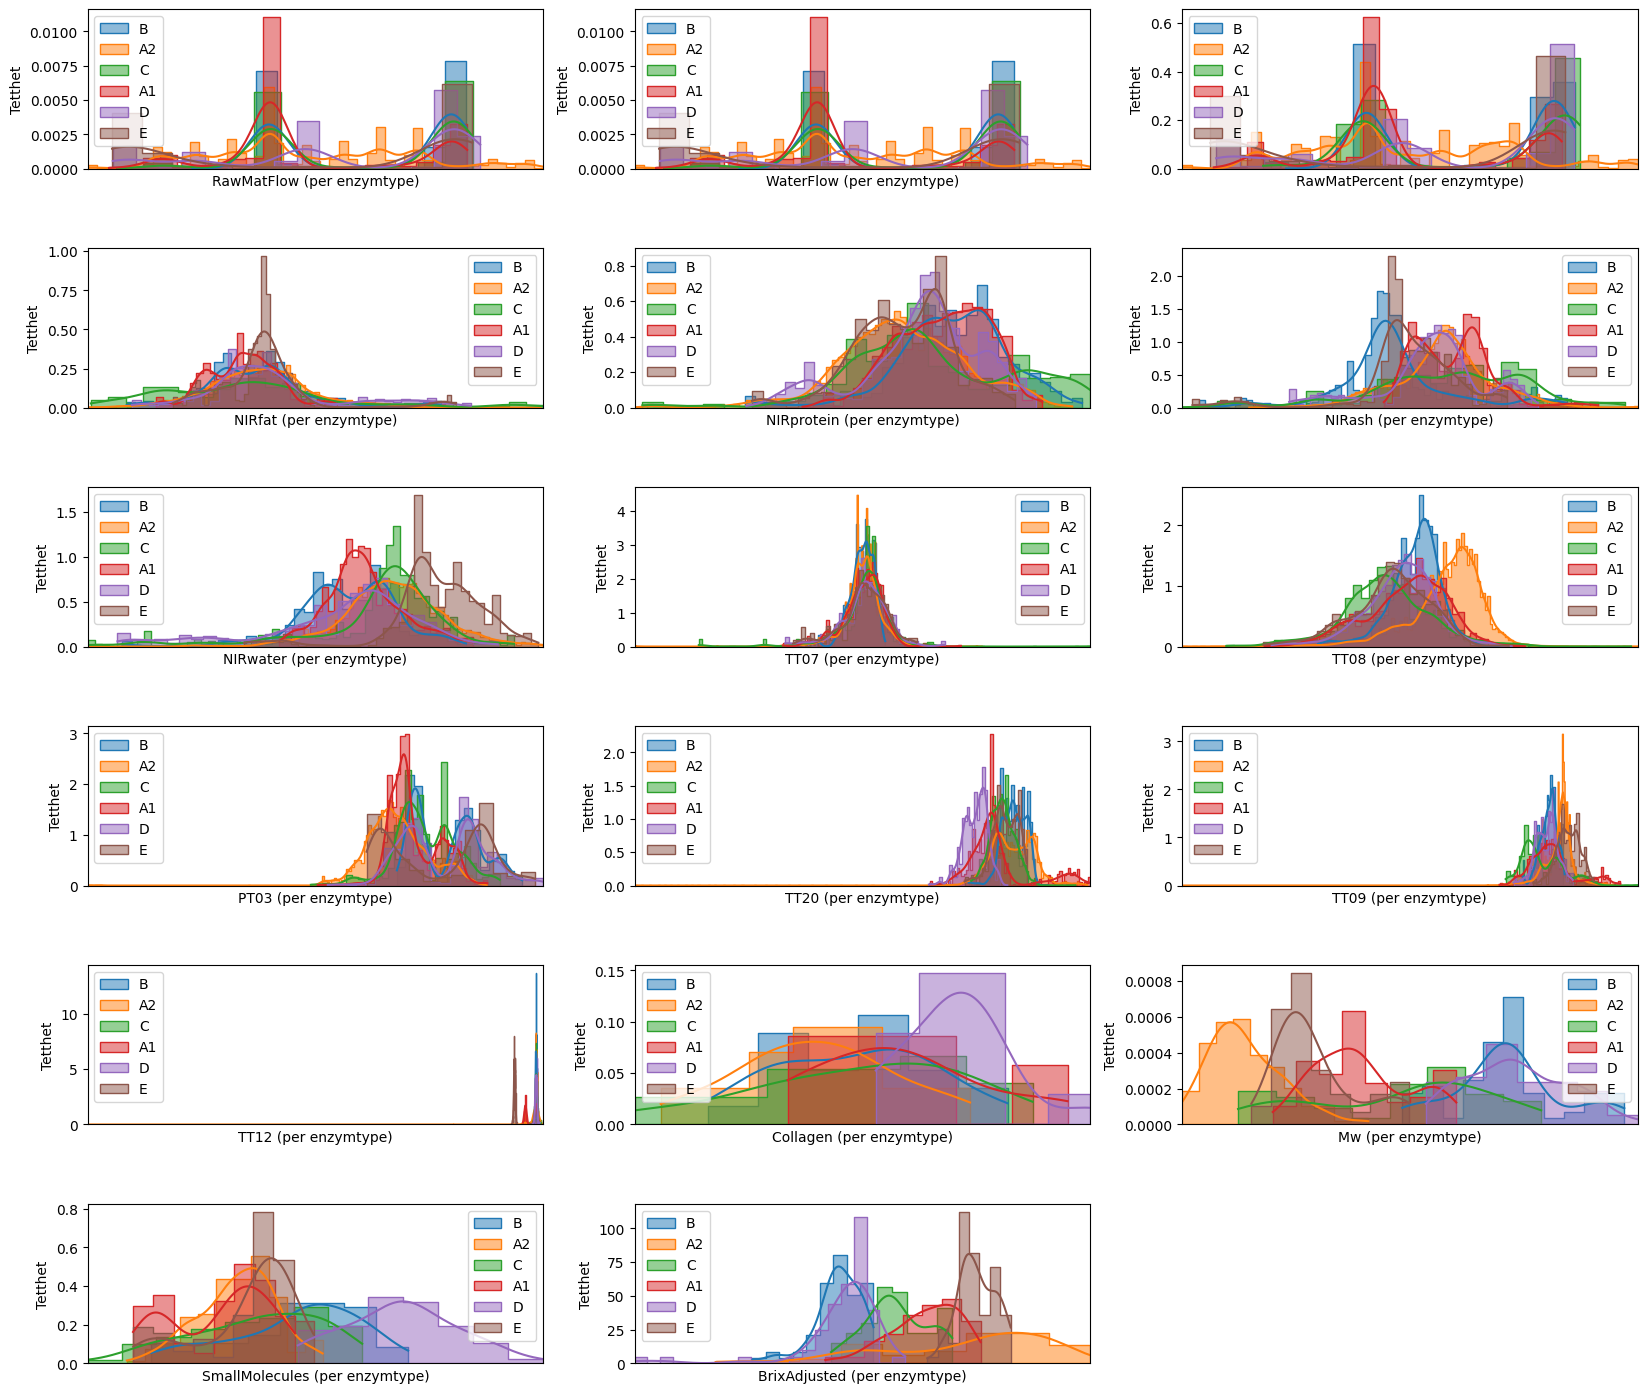

In [ ]:
plot_histogram_enzym(bioco_data_tid,
                     "EnzymeCode",
                     min_max_dict=min_max_dict_hel,
                     figsize=(20, 30))

Fordeling i variablene for hele datasettet med uke- og dagsinformasjon

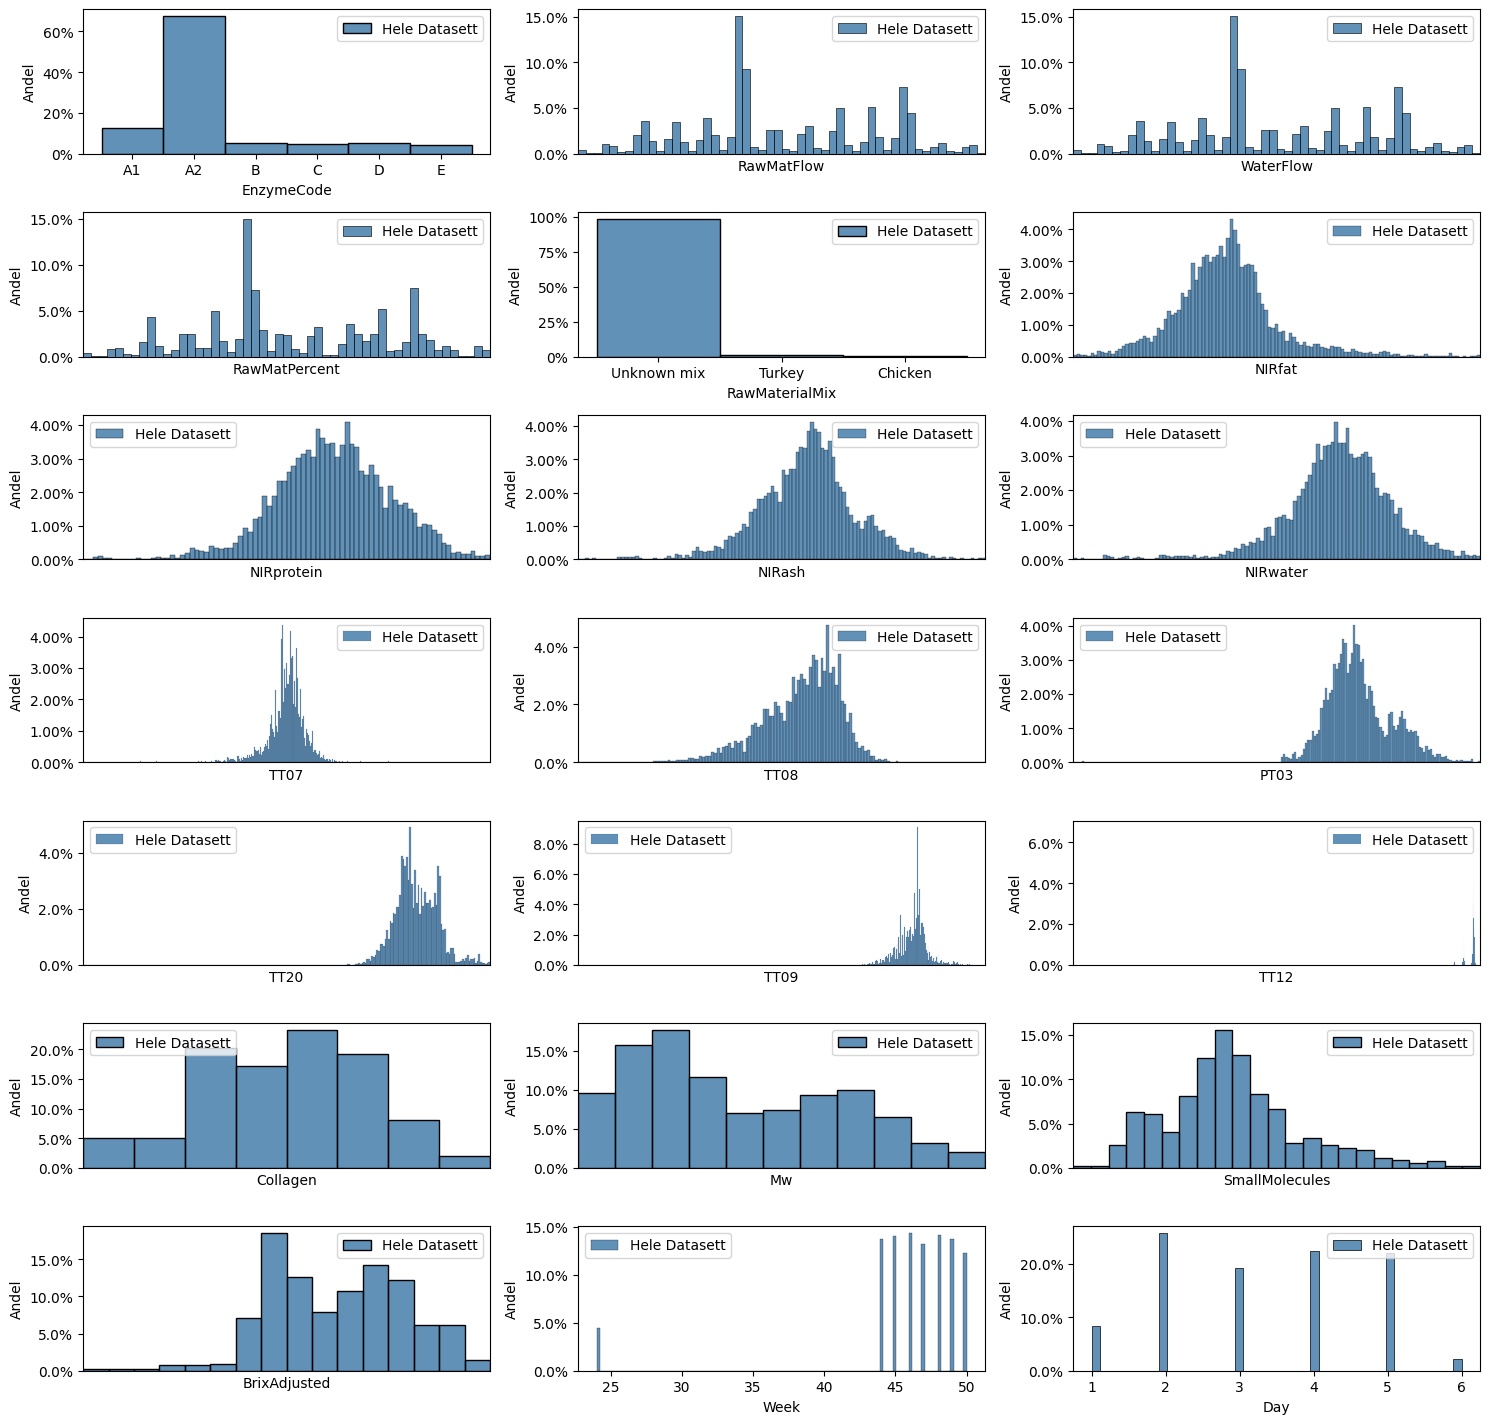

In [ ]:
plot_histogram(df1=bioco_data_tid,
               df2=None,
               labels=['Hele Datasett'],
               min_max_dict=min_max_dict_hel,
               figsize=(15, 20))

Fordeling av Enzymtyper og råmaterialetyper i hele datasett

In [ ]:
kategoriske_fordelinger(bioco_data_tid)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 29213      | 67.5429     |
| A1           | 5482       | 12.6749     |
| D            | 2272       | 5.25306     |
| B            | 2270       | 5.24843     |
| C            | 2080       | 4.80914     |
| E            | 1934       | 4.47157     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 42607      | 98.511      |
| Turkey           | 355        | 0.82079     |
| Chicken          | 289        | 0.668193    |


## Fordeling i markert og umarkert del av datasett

Datasett for markert og umarkert del av hele datasett

In [ ]:
# Deler opp datasett i markert og umarkert andel etter Collagen som respons
collagen_markert, collagen_umarkert = splitt_markert_umarkert_respons(bioco_data_tid,
                                                                      "Collagen")

kvalitetsmålinger_markert, kvalitetsmålinger_umarkert = splitt_markert_umarkert_respons(bioco_data_tid,
                                                                      "Mw")

Fordeling i datasett med Collagen som markert respons

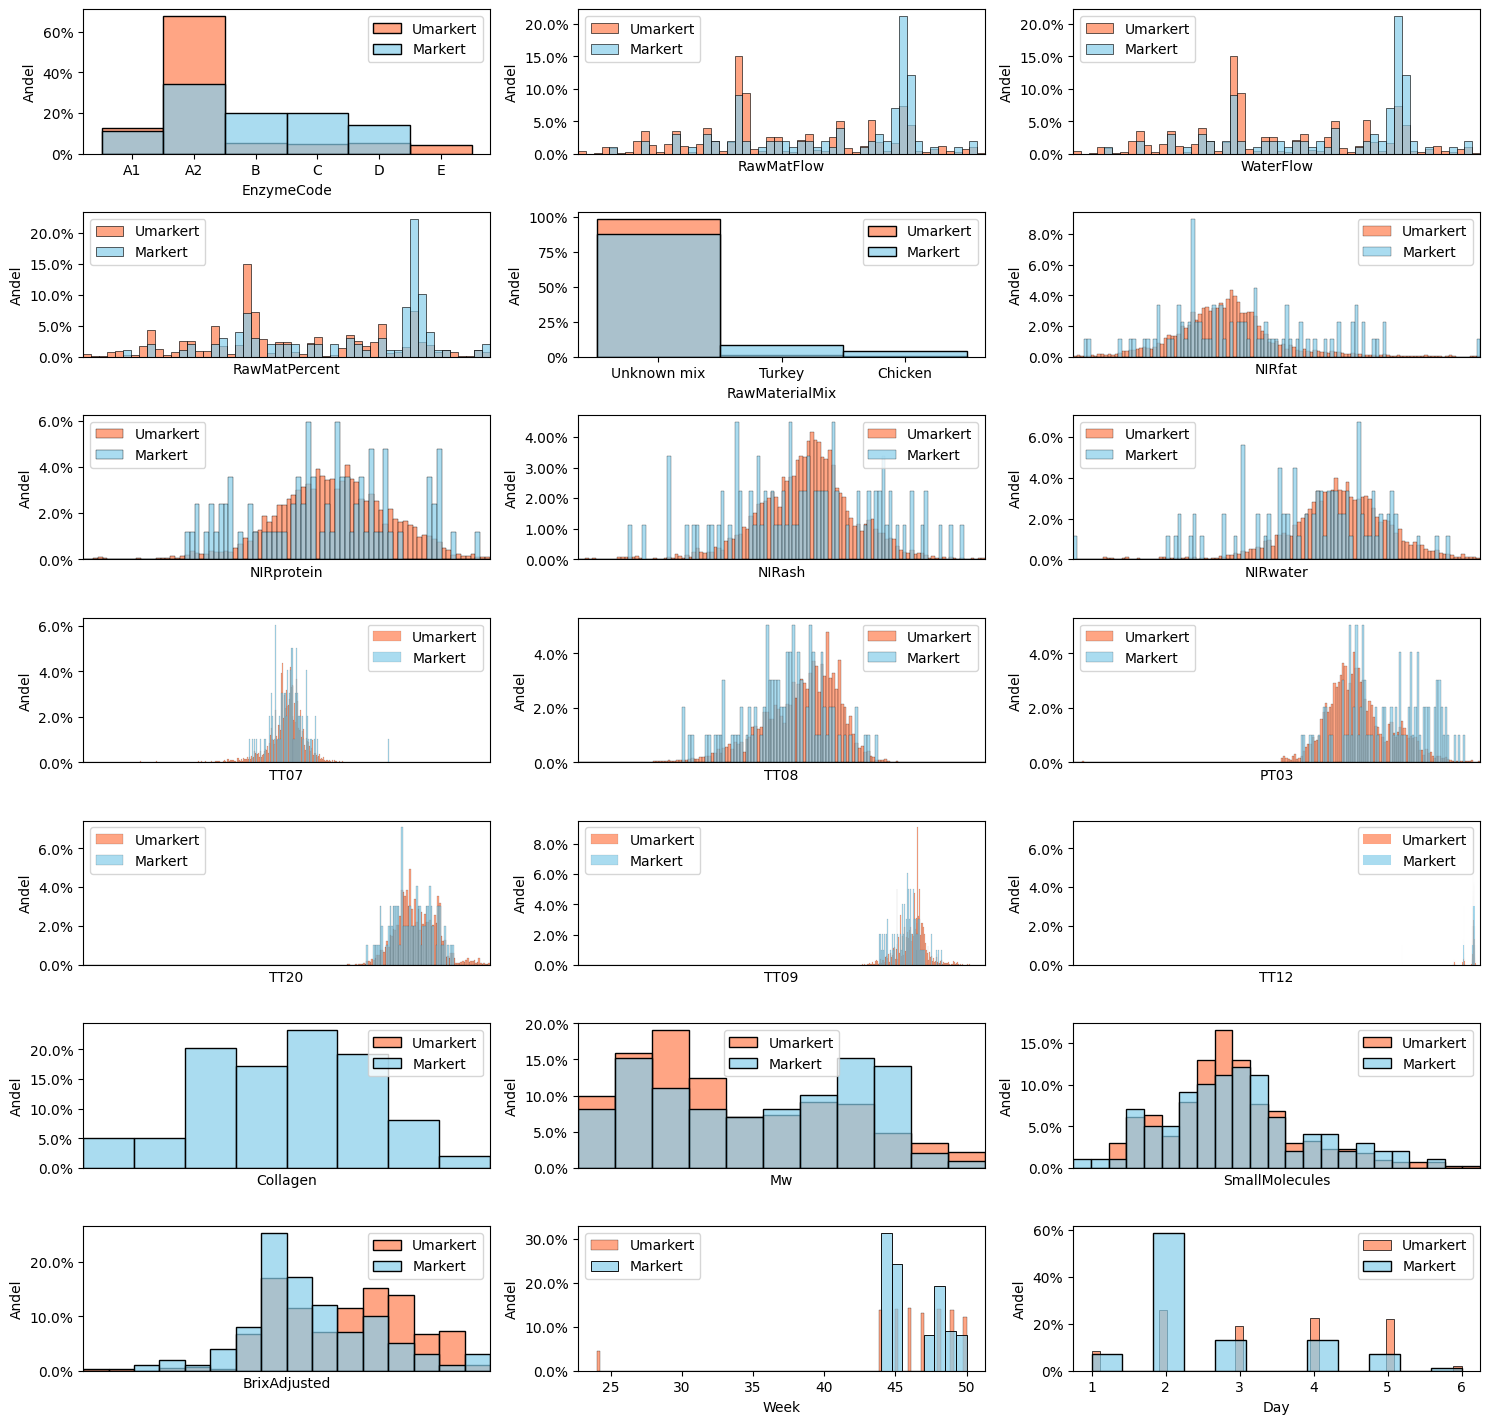

In [ ]:
plot_histogram(df1=collagen_markert,
               df2=collagen_umarkert,
               labels=['Markert', 'Umarkert'],
               min_max_dict=min_max_dict_hel,
               figsize=(15, 20))

Fordeling av kategorier i markert delsett med Collagen som markert respons

In [ ]:
kategoriske_fordelinger(collagen_markert)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 34         | 34.3434     |
| B            | 20         | 20.202      |
| C            | 20         | 20.202      |
| D            | 14         | 14.1414     |
| A1           | 11         | 11.1111     |
| E            | 0          | 0           |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 87         | 87.8788     |
| Turkey           | 8          | 8.08081     |
| Chicken          | 4          | 4.0404      |


Fordeling av kategorier i umarkert delsett med Collagen som markert respons

In [ ]:
kategoriske_fordelinger(collagen_umarkert)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 29179      | 67.6191     |
| A1           | 5471       | 12.6784     |
| D            | 2258       | 5.23267     |
| B            | 2250       | 5.21413     |
| C            | 2060       | 4.77382     |
| E            | 1934       | 4.48183     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 42520      | 98.5354     |
| Turkey           | 347        | 0.804134    |
| Chicken          | 285        | 0.660456    |


Fordeling i datasett med resterende kvalitetsmålinger som markert respons

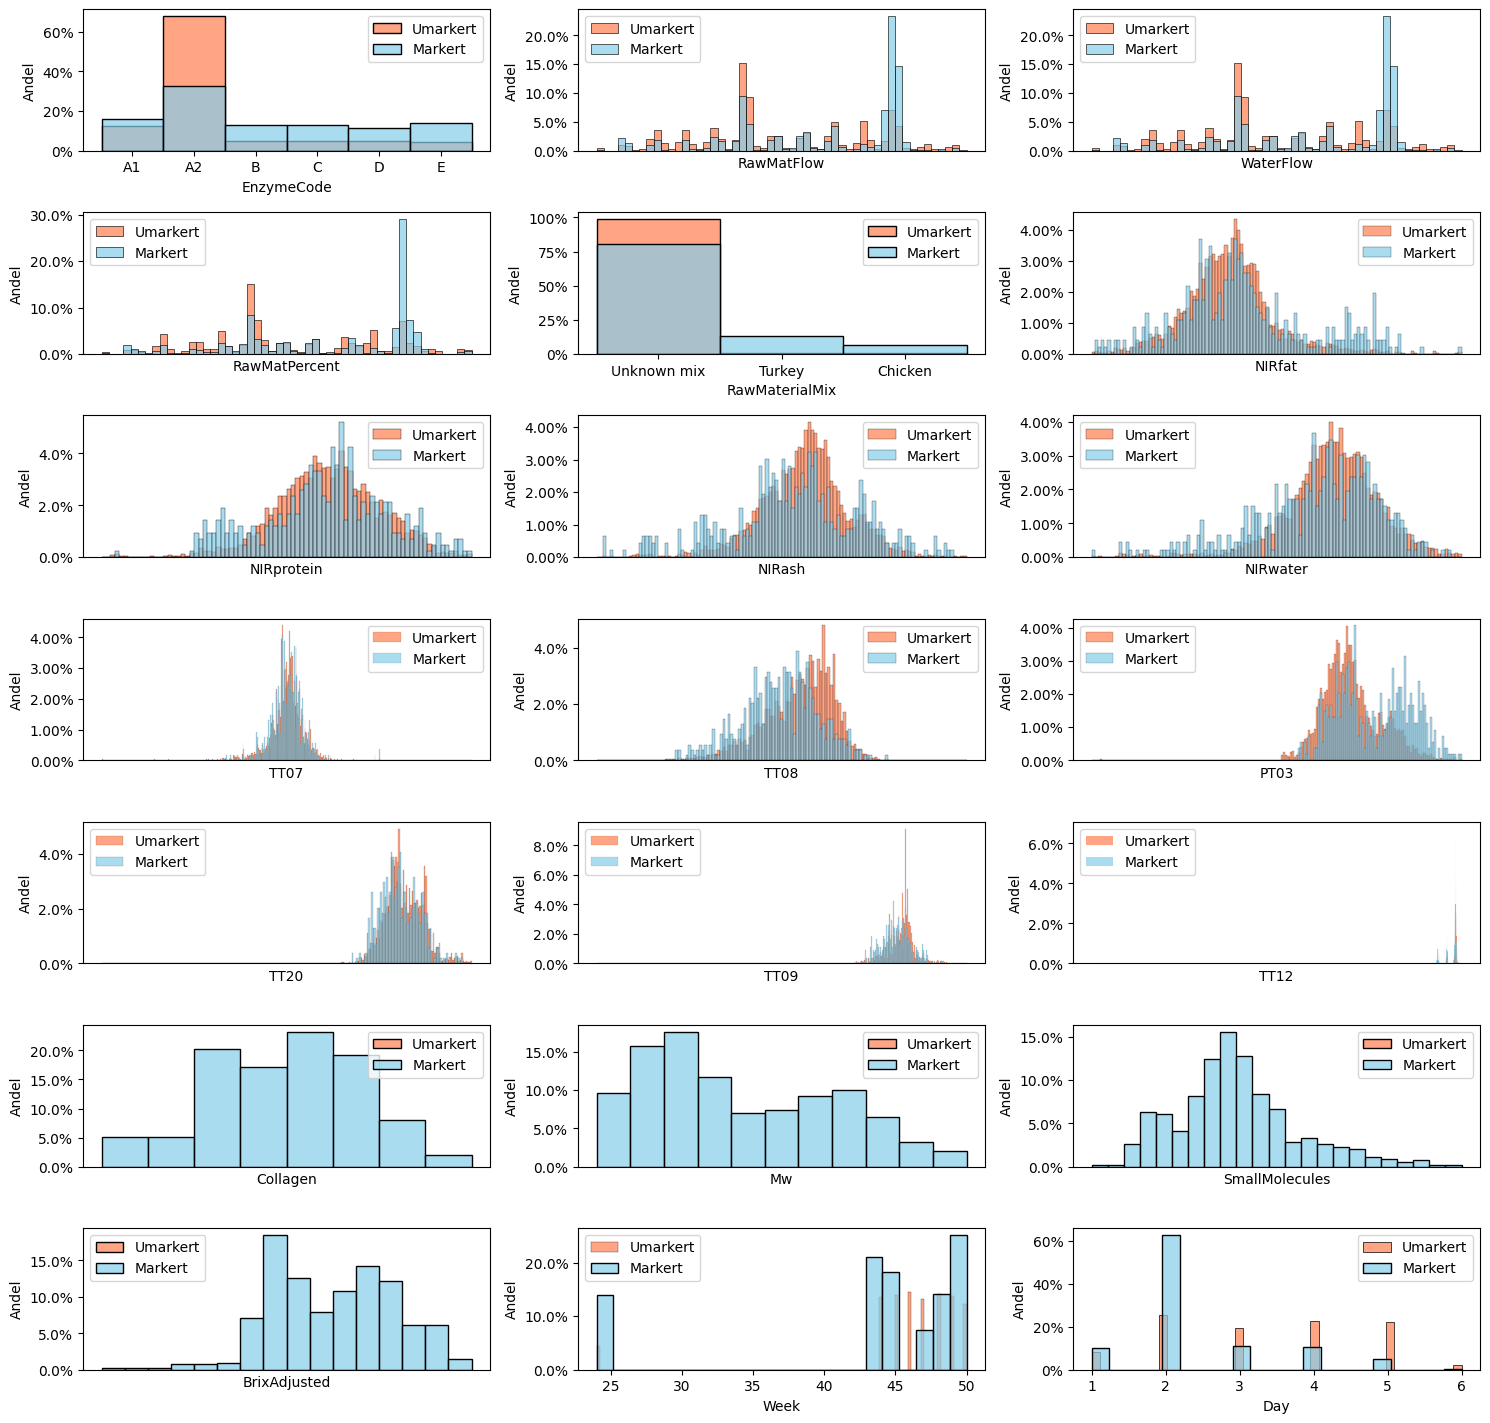

In [ ]:
plot_histogram(df1=kvalitetsmålinger_markert,
               df2=kvalitetsmålinger_umarkert,
               labels=['Markert', 'Umarkert'],
               figsize=(15, 20))

Fordeling av kategorier i markert datasett med andre kvalitetsmålinger som markert respons

In [ ]:
kategoriske_fordelinger(kvalitetsmålinger_markert)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 176        | 32.5926     |
| A1           | 86         | 15.9259     |
| E            | 75         | 13.8889     |
| B            | 70         | 12.963      |
| C            | 70         | 12.963      |
| D            | 63         | 11.6667     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 435        | 80.5556     |
| Turkey           | 71         | 13.1481     |
| Chicken          | 34         | 6.2963      |


Fordeling av kategorier i umarkert delsett med andre kvalitetsmålinger som markert respons

In [ ]:
kategoriske_fordelinger(kvalitetsmålinger_umarkert)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A2           | 29037      | 67.9848     |
| A1           | 5396       | 12.6337     |
| D            | 2209       | 5.17197     |
| B            | 2200       | 5.1509      |
| C            | 2010       | 4.70605     |
| E            | 1859       | 4.35251     |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 42172      | 98.738      |
| Turkey           | 284        | 0.664934    |
| Chicken          | 255        | 0.597036    |


## Designproduksjon (Uten enzym A2)

In [ ]:
# Ekskluderer de dager med "normal"-produksjon
data_designprod = bioco_data_tid[bioco_data_tid['EnzymeCode'] != 'A2'].copy()

In [ ]:
data_designprod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14038 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   EnzymeCode      14038 non-null  category
 1   RawMatFlow      13983 non-null  float64 
 2   WaterFlow       13983 non-null  float64 
 3   RawMatPercent   13983 non-null  float64 
 4   RawMaterialMix  14038 non-null  object  
 5   NIRfat          10880 non-null  float64 
 6   NIRprotein      10383 non-null  float64 
 7   NIRash          10900 non-null  float64 
 8   NIRwater        10937 non-null  float64 
 9   TT07            13988 non-null  float64 
 10  TT08            13993 non-null  float64 
 11  PT03            14013 non-null  float64 
 12  TT20            14013 non-null  float64 
 13  TT09            14023 non-null  float64 
 14  TT12            14038 non-null  float64 
 15  Collagen        65 non-null     float64 
 16  Mw              364 non

Hele delsett

In [ ]:
kategoriske_fordelinger(data_designprod)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A1           | 5482       | 39.0511     |
| D            | 2272       | 16.1846     |
| B            | 2270       | 16.1704     |
| C            | 2080       | 14.8169     |
| E            | 1934       | 13.7769     |
| A2           | 0          | 0           |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 13499      | 96.1604     |
| Turkey           | 300        | 2.13706     |
| Chicken          | 239        | 1.70252     |


In [ ]:
# Lager et datasett for de resterende kvalitetsmålinger
kvalitetsmålinger_markert_design, kvalitetsmåligner_umarkert_design= splitt_markert_umarkert_respons(data_designprod,
                                                                                                     "Mw")

Fordeling i datasett med resterende kvalitetsmålinger som markert respons

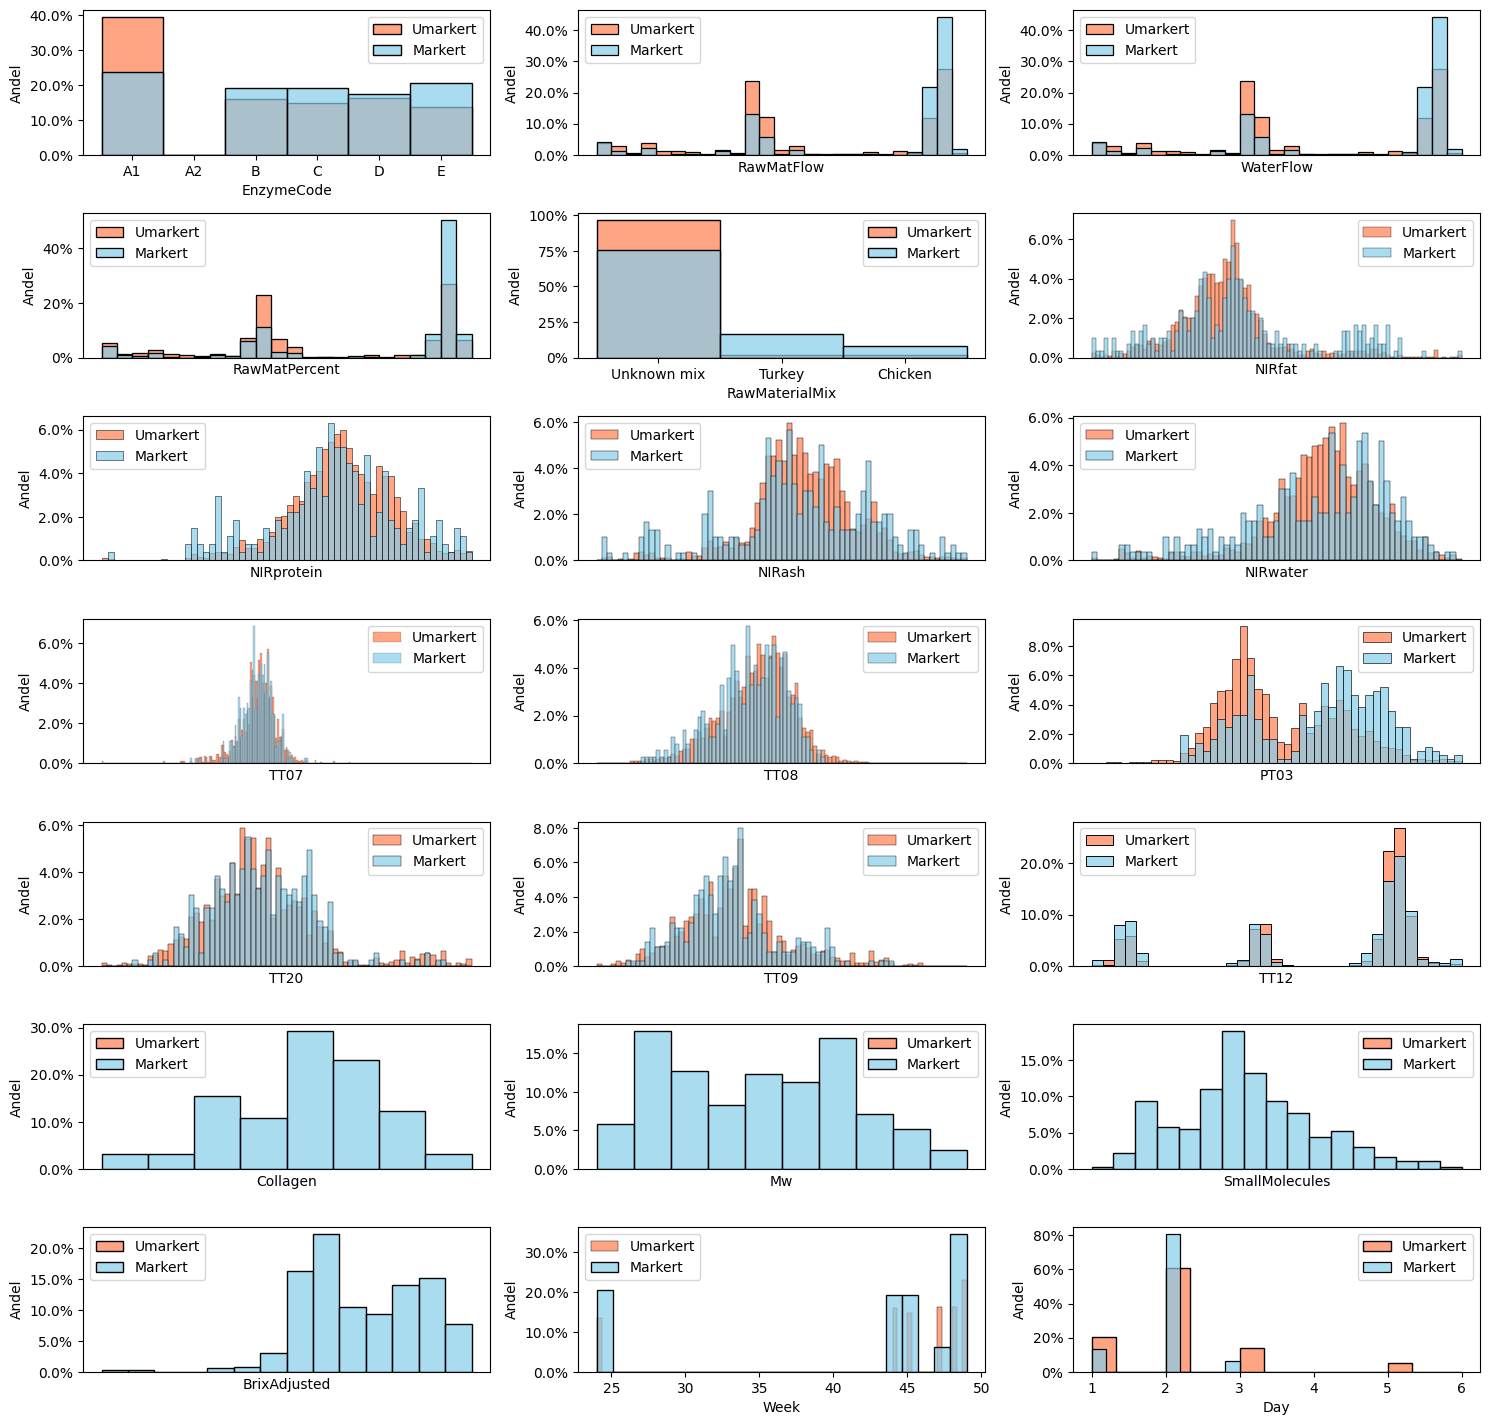

In [ ]:
plot_histogram(df1=kvalitetsmålinger_markert_design,
               df2=kvalitetsmåligner_umarkert_design,
               labels=['Markert', 'Umarkert'],
               figsize=(15, 20))

In [ ]:
kategoriske_fordelinger(kvalitetsmålinger_markert_design)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A1           | 86         | 23.6264     |
| E            | 75         | 20.6044     |
| B            | 70         | 19.2308     |
| C            | 70         | 19.2308     |
| D            | 63         | 17.3077     |
| A2           | 0          | 0           |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 274        | 75.2747     |
| Turkey           | 60         | 16.4835     |
| Chicken          | 30         | 8.24176     |


In [ ]:
kategoriske_fordelinger(kvalitetsmåligner_umarkert_design)


**Fordelingen i 'EnzymeCode':**
| EnzymeCode   | Frekvens   | Andel (%)   |
|:-------------|:-----------|:------------|
| A1           | 5396       | 39.4618     |
| D            | 2209       | 16.1547     |
| B            | 2200       | 16.0889     |
| C            | 2010       | 14.6994     |
| E            | 1859       | 13.5951     |
| A2           | 0          | 0           |

**Fordelingen i 'RawMaterialMix':**
| RawMaterialMix   | Frekvens   | Andel (%)   |
|:-----------------|:-----------|:------------|
| Unknown mix      | 13225      | 96.7164     |
| Turkey           | 240        | 1.75516     |
| Chicken          | 209        | 1.52845     |


# Behandling av kategoriske variabler

Behandling av kategorisk variabel "RawmaterialMix"

In [ ]:
# Koverterer "RawMaterialMix" fra kategorisk variabel til numeriske varaibler for
# hver respektive enzymtype
bioco_data = pd.get_dummies(bioco_data,
                            columns=["RawMaterialMix"],
                            prefix=["RawMaterialMix"],
                            dtype=int)

# Reorgoniserer kolonnene, slik at enzymtype-informasjonen er de fremste
kolonne_rekkefølge = (bioco_data.columns[-3:].to_list() +
                      bioco_data.columns[:-3].to_list())
bioco_data = bioco_data[kolonne_rekkefølge]

Behandling av kategorisk variabel "EnzymeCode"

In [ ]:
# Koverterer "EnzymeCode" fra kategorisk variabel til numeriske varaibler for
# hver respektive enzymtype
bioco_data = pd.get_dummies(bioco_data,
                            columns=["EnzymeCode"],
                            prefix=["EnzymeType"],
                            dtype=int)

# Reorgoniserer kolonnene, slik at enzymtype-informasjonen er de fremste
kolonne_rekkefølge = (bioco_data.columns[-6:].to_list() +
                      bioco_data.columns[:-6].to_list())
bioco_data = bioco_data[kolonne_rekkefølge]

#Korrelasjon

Korrelasjonsmatriale med NIR målinger

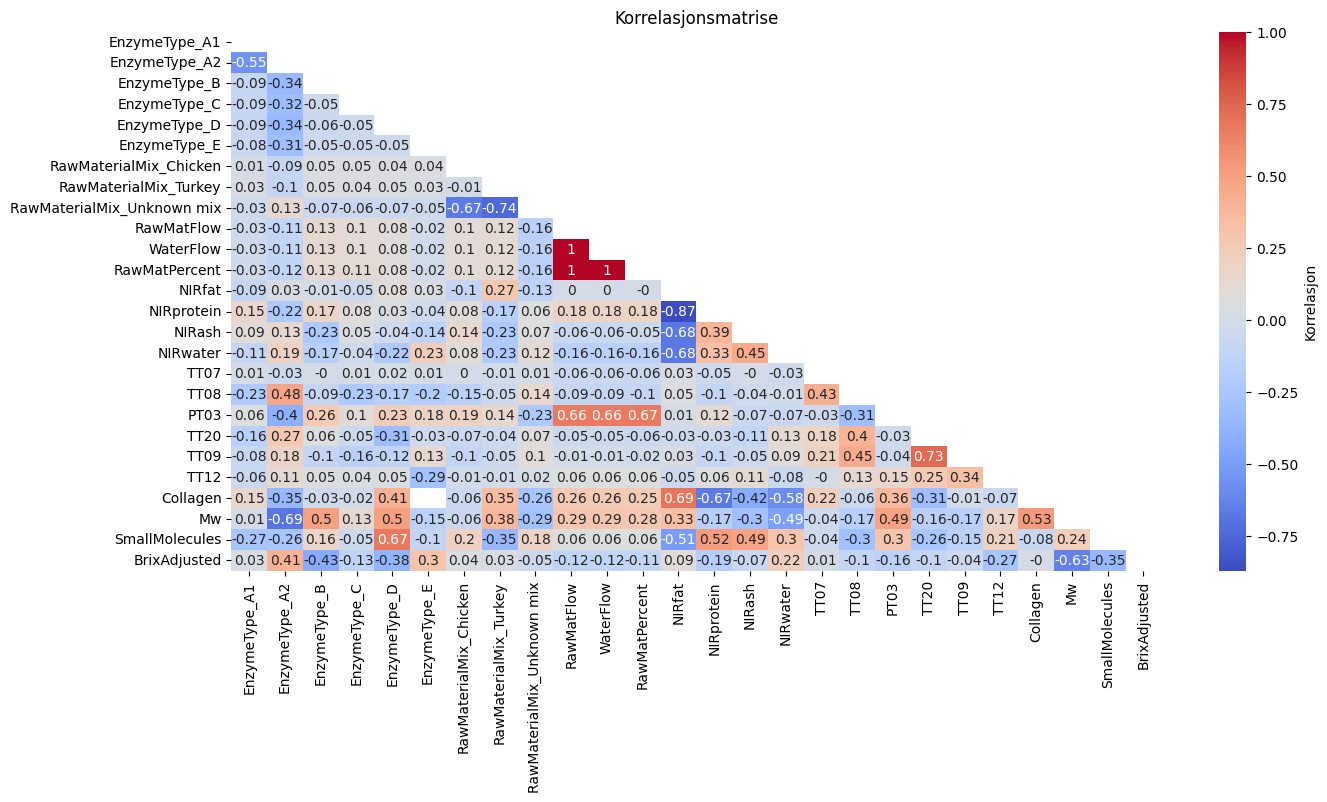

In [ ]:
# Lager en korrelasjonsmatrise med annotering
korrelasjon_matrise = bioco_data.corr()

# Runder av til 2 desimaler for bedre lesbarhet
korrelasjon_matrise_avrundet = korrelasjon_matrise.round(2)

# Triangulær matrise
maske = np.triu(np.ones_like(korrelasjon_matrise_avrundet,
                             dtype=bool))

plt.figure(figsize=(15, 7))
sns.heatmap(korrelasjon_matrise_avrundet,
            annot=True,
            mask=maske,
            cmap='coolwarm',
            cbar_kws={'label': 'Korrelasjon'})
plt.title("Korrelasjonsmatrise")
plt.show()

# PCA - analyse

## Med fjerning av manglende data og standarisering

In [ ]:
# Lager kopi av behandlet data
forklaring_data = copy.deepcopy(bioco_data)

# Dropper responsvariabler
forklaring_data.drop(forklaring_data.columns[-4:], axis=1, inplace=True)

# Navn på forklaringsvariabler
variabel_navn = list(forklaring_data.columns)

forklaring_behandlet = forklaring_data.dropna().to_numpy()

# pca modell
pca_modell = ho.nipalsPCA(arrX=forklaring_behandlet,
                          Xstand=True,
                          numComp=5)

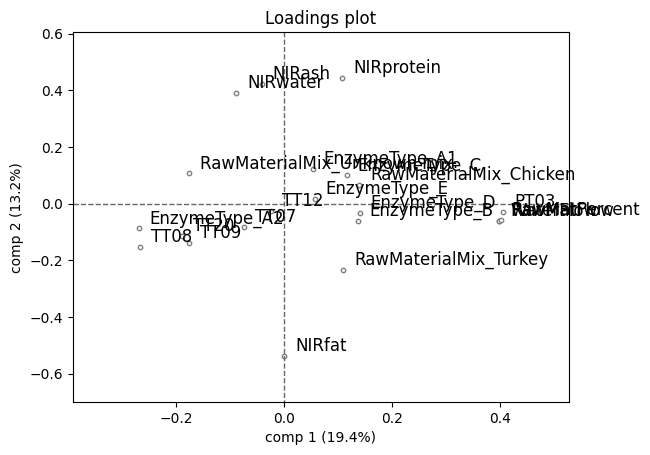

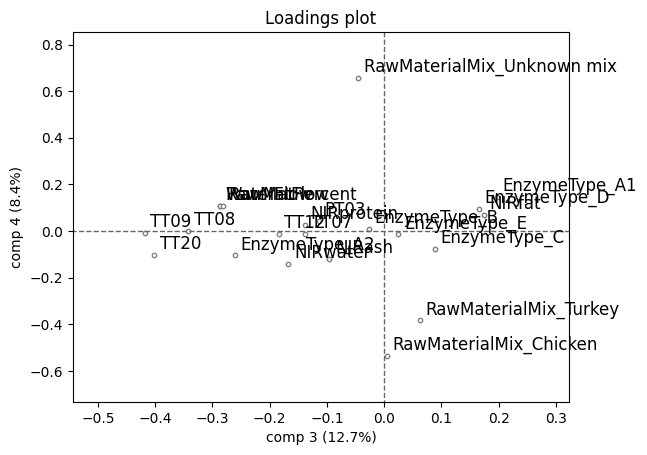

In [ ]:
# pca plot component 1 and 2
hop.plot(pca_modell, comp = [1,2],
         plots = [2],
         XvarNames=variabel_navn)

# pca plt component 3 and 4
hop.plot(pca_modell, comp = [3,4],
         plots = [2],
         XvarNames=variabel_navn)

Uten NIR målinger

In [ ]:
# Lager kopi av behandlet data
forklaring_data_uten_NIR = copy.deepcopy(forklaring_data)

# Utelukker NIR målinger
nir_målinger = ['NIRfat', 'NIRprotein', 'NIRash', 'NIRwater']

forklaring_data_uten_NIR.drop(columns = nir_målinger, inplace=True)

# Navn på forklaringsvariabler
variabel_navn_uten_NIR = list(forklaring_data_uten_NIR.columns)

forklaring_behandlet_uten_NIR = forklaring_data_uten_NIR.dropna().to_numpy()

# pca modell
pca_modell_uten_NIR = ho.nipalsPCA(arrX=forklaring_behandlet_uten_NIR,
                          Xstand=True,
                          numComp=5)

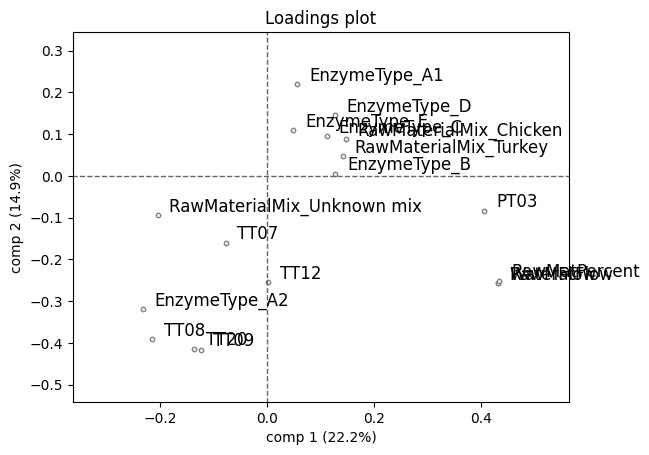

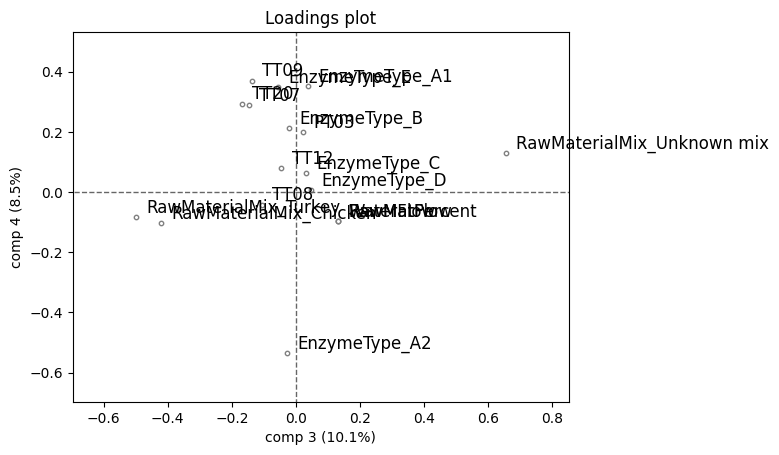

In [ ]:
# pca plot component 1 and 2
hop.plot(pca_modell_uten_NIR, comp = [1,2],
         plots = [2],
         XvarNames=variabel_navn_uten_NIR)

# pca plt component 3 and 4
hop.plot(pca_modell_uten_NIR, comp = [3,4],
         plots = [2],
         XvarNames=variabel_navn_uten_NIR)

# Utelukking av variabler etter vurdering

In [ ]:
# Dropper "RawMaterialMix", da det meste av datasettet består av Unknown mix
bioco_data.drop(columns=['RawMaterialMix_Chicken',
                         'RawMaterialMix_Turkey',
                         'RawMaterialMix_Unknown mix'],
                inplace=True)

# Dropper kolonner "RawMatFlow" og "WaterFlow" som er høyt korrelert med
# RawMatPercent
bioco_data.drop(columns=['RawMatFlow','WaterFlow'],
                inplace = True)

# Dropper kolonne "NIRprotein" som er høyt korrelert med NIRfat
bioco_data.drop(columns=['NIRprotein'],
                inplace = True)

# Dropper kolonne "TT07", som er tilnærmet lik konstant verdi
bioco_data.drop(columns=['TT07'],
                inplace = True)

# Dropper kolonne "PT03" som er høyt korrelert med RawMatPercent og
# en direkte konsekvens av flow
bioco_data.drop(columns=['PT03'],
                inplace = True)

# Dropper kolonne "TT09" som er høyt korrelert med TT20
bioco_data.drop(columns=['TT09'],
                inplace = True)

# Førbehandlet datasett

Informasjon om de gjenverende kolonner etter behandling

In [ ]:
bioco_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   43251 non-null  int64  
 1   EnzymeType_A2   43251 non-null  int64  
 2   EnzymeType_B    43251 non-null  int64  
 3   EnzymeType_C    43251 non-null  int64  
 4   EnzymeType_D    43251 non-null  int64  
 5   EnzymeType_E    43251 non-null  int64  
 6   RawMatPercent   43196 non-null  float64
 7   NIRfat          29064 non-null  float64
 8   NIRash          29275 non-null  float64
 9   NIRwater        29293 non-null  float64
 10  TT08            43206 non-null  float64
 11  TT20            43226 non-null  float64
 12  TT12            43251 non-null  float64
 13  Collagen        99 non-null     float64
 14  Mw              540 non-null    float64
 15  SmallMolecules  540 non-null    float64
 16  BrixAdjusted    540 non-null    float64
d

Korrelasjonsmatrise

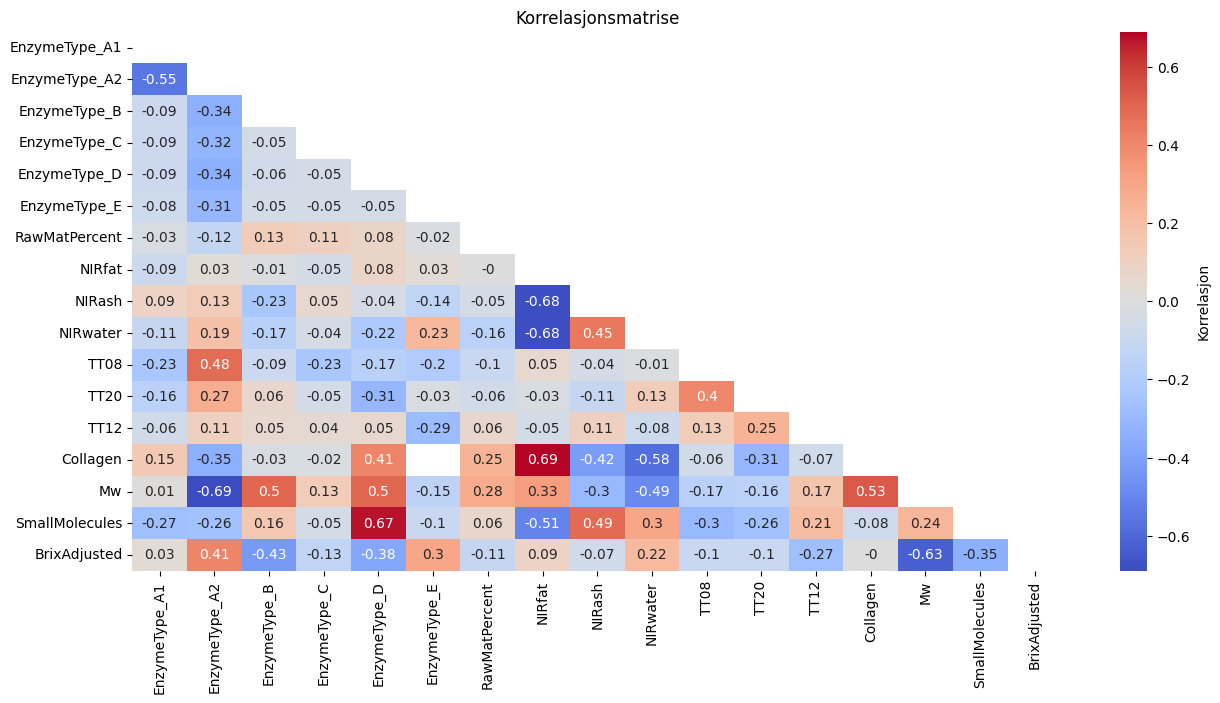

In [ ]:
# Lager en korrelasjonsmatrise med annotering
korrelasjon_matrise = bioco_data.corr()

# Runder av til 2 desimaler for bedre lesbarhet
korrelasjon_matrise_avrundet = korrelasjon_matrise.round(2)

# Triangulær matrise
maske = np.triu(np.ones_like(korrelasjon_matrise_avrundet,
                             dtype=bool))

plt.figure(figsize=(15, 7))
sns.heatmap(korrelasjon_matrise_avrundet,
            annot=True,
            mask=maske,
            cmap='coolwarm',
            cbar_kws={'label': 'Korrelasjon'})
plt.title("Korrelasjonsmatrise")
plt.show()

# Statistisk informasjom om kvalitetsmålinger, fordelt på kategoriske variabler

In [ ]:
res_ops_kategori = respons_kategori(bioco_rå_data, bioco_data, ['Mw', 'SmallMolecules', 'BrixAdjusted'])

**Mw**

In [ ]:
res_ops_kategori['Mw']

mean                                   median  \
RawMaterialMix      Chicken        Turkey   Unknown mix      Chicken   
EnzymeCode                                                             
A1              6115.612172   8615.006689   6987.639187  6115.072271   
A2              3790.494744   5779.150443   4895.026420  3785.614245   
B               8451.373819  12040.168650   9918.510465  8489.670172   
C               6306.278958  10211.720768   7740.604263  6222.793155   
D               9203.356027  11519.818886  10106.256521  9064.406891   
E               5638.579804   8032.599018   6169.841916  5596.048427   

                                                   std              \
RawMaterialMix        Turkey   Unknown mix     Chicken      Turkey   
EnzymeCode                                                           
A1               8725.370797   6981.864477  248.475917  239.189529   
A2               5704.773386   4738.251028   17.240382  132.358165   
B               12065.478898  10086.164090  258.314462  307.900972   
C               10297.589029   8420.162031  315.591446  487.109345   
D               11547.249066  10148.692987  303.305312  231.236522   
E                8071.185994   6057.287682  122.398268  141.170013   

                             
RawMaterialMix  Unknown mix  
EnzymeCode                   
A1               681.923255  
A2               714.492345  
B                623.105499  
C               1649.362692  
D                882.774154  
E                575.288062

**BrixAdjusted**

In [ ]:
res_ops_kategori['BrixAdjusted']

mean                          median            \
RawMaterialMix   Chicken    Turkey Unknown mix   Chicken    Turkey   
EnzymeCode                                                           
A1              0.113128  0.112524    0.105053  0.112029  0.112310   
A2              0.137193  0.140860    0.114901  0.135815  0.140960   
B               0.079697  0.088499    0.085117  0.082747  0.089576   
C               0.109651  0.097053    0.099491  0.109550  0.098199   
D               0.091478  0.091670    0.084312  0.090546  0.091451   
E               0.125589  0.118578    0.119577  0.124924  0.117325   

                                 std                        
RawMaterialMix Unknown mix   Chicken    Turkey Unknown mix  
EnzymeCode                                                  
A1                0.105087  0.005199  0.005287    0.008737  
A2                0.121562  0.002908  0.001267    0.020247  
B                 0.085427  0.005482  0.004244    0.005915  
C                 0.098748  0.001726  0.002137    0.008216  
D                 0.087599  0.001389  0.001910    0.011814  
E                 0.119707  0.001438  0.001950    0.004752

**SmallMolecules**

In [ ]:
res_ops_kategori['SmallMolecules']

mean                            median             \
RawMaterialMix    Chicken     Turkey Unknown mix    Chicken     Turkey   
EnzymeCode                                                               
A1              11.224147   8.592447   10.250605  11.181043   8.608835   
A2              11.786083   9.277207   10.423598  11.816138   9.268269   
B               12.898245   9.347330   12.024435  12.794579   9.248648   
C               11.764897   8.745844   11.058613  11.721981   8.798255   
D               14.328340  12.462014   14.216494  14.509017  12.436247   
E               11.408280   8.476436   10.777326  11.427473   8.483215   

                                 std                        
RawMaterialMix Unknown mix   Chicken    Turkey Unknown mix  
EnzymeCode                                                  
A1               10.452722  0.205506  0.234151    0.833181  
A2               10.530471  0.091795  0.123001    0.765169  
B                11.968128  0.361691  0.526240    0.906387  
C                11.101924  0.271737  0.389868    1.218444  
D                13.962739  0.316720  0.463543    1.094697  
E                10.996946  0.234505  0.208804    0.727064

Lagre førbehandlet data som csv

In [ ]:
bioco_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/førbehandlet_bioco_data.csv')